Loading data and computing Tail Wasserstein-1 distances...

Pooling Wasserstein distances across all scenarios...

Percentile cutpoints:
  P25 = 0.2546
  P75 = 1.0047
  P90 = 1.6862


/tmp/ipykernel_143784/3087708842.py:240: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.10, 1.0, 0.95])


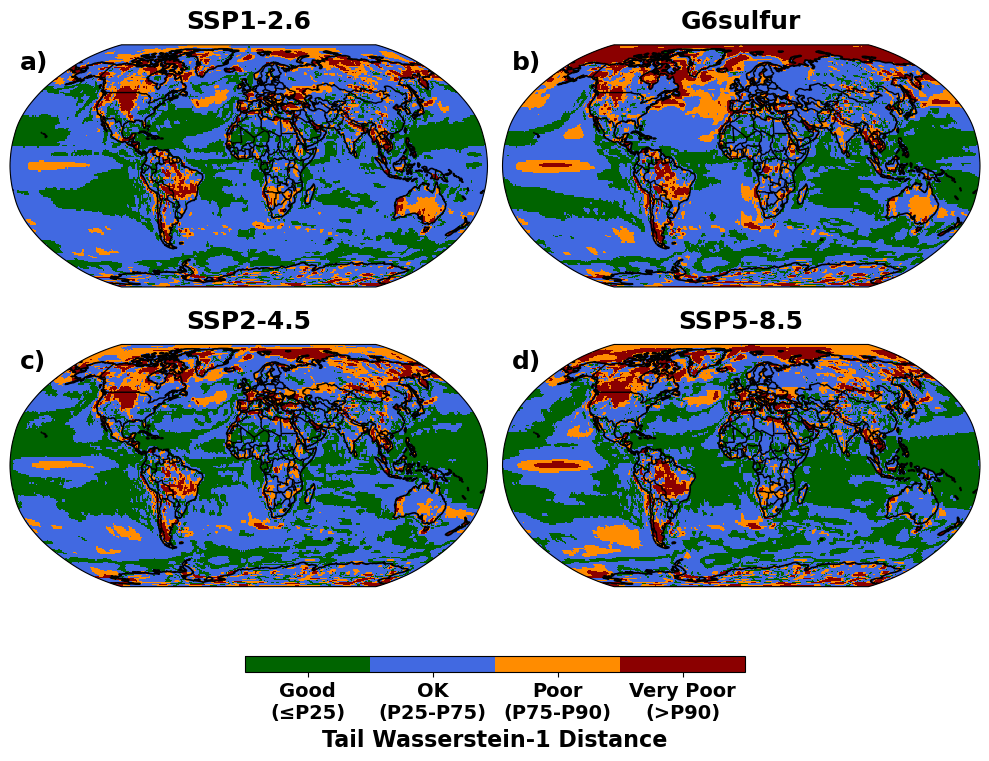

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

# Configuration
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

var_name = 'tas'
scenarios = ['ssp126', 'g6sulfur', 'ssp245', 'ssp585']

scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'g6sulfur': 'G6sulfur',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Model to use (PLD-Res)
model_key = 'pred_grid'

# Time period: 2020-2099 for all scenarios
time_slice = slice('2020', '2099')

# Tail threshold (focus on upper tail from 90th percentile)
q_threshold = 0.90

def compute_tail_wasserstein(pred_timeseries, truth_timeseries, q_threshold=0.90, n_quantiles=50):
    """
    Compute Tail Wasserstein-1 distance for a single time series.
    
    W^(q) = ∫[q to 1] |Q^pred(p) - Q^true(p)| dp
    
    Args:
        pred_timeseries: 1D array of predictions over time
        truth_timeseries: 1D array of ground truth over time
        q_threshold: Lower bound of tail (e.g., 0.90 for 90th percentile)
        n_quantiles: Number of quantile points to evaluate in [q_threshold, 1.0]
    
    Returns:
        wasserstein_distance: Scalar tail Wasserstein-1 distance
    """
    # Remove NaNs
    pred_clean = pred_timeseries[~np.isnan(pred_timeseries)]
    truth_clean = truth_timeseries[~np.isnan(truth_timeseries)]
    
    if len(pred_clean) < 10 or len(truth_clean) < 10:
        return np.nan
    
    # Create quantile levels in tail region
    p_levels = np.linspace(q_threshold, 1.0, n_quantiles)
    
    # Compute quantiles for prediction and truth
    q_pred = np.quantile(pred_clean, p_levels)
    q_truth = np.quantile(truth_clean, p_levels)
    
    # Compute absolute differences
    abs_diff = np.abs(q_pred - q_truth)
    
    # Integrate using trapezoidal rule
    # ∫[q to 1] |Q^pred(p) - Q^true(p)| dp
    wasserstein_distance = np.trapz(abs_diff, p_levels)
    
    wasserstein_distance /= (1.0 - q_threshold)
    
    return wasserstein_distance

def compute_spatial_tail_wasserstein(pred_data, truth_data, q_threshold=0.90):
    """
    Compute Tail Wasserstein-1 distance for each grid point.
    
    Args:
        pred_data: 3D array (time, lat, lon)
        truth_data: 3D array (time, lat, lon)
        q_threshold: Lower bound of tail
    
    Returns:
        wasserstein_map: 2D array (lat, lon) of Wasserstein distances
    """
    n_time, n_lat, n_lon = pred_data.shape
    wasserstein_map = np.zeros((n_lat, n_lon))
    
    for i in range(n_lat):
        for j in range(n_lon):
            pred_ts = pred_data[:, i, j]
            truth_ts = truth_data[:, i, j]
            
            wasserstein_map[i, j] = compute_tail_wasserstein(
                pred_ts, truth_ts, q_threshold=q_threshold
            )
    
    return wasserstein_map

# Load data and compute Wasserstein distances
print("Loading data and computing Tail Wasserstein-1 distances...")
wasserstein_maps = {}

for scenario in scenarios:
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    
    if not residual_file.exists():
        print(f"  Warning: File not found for {scenario}")
        continue
    
    ds = xr.open_dataset(residual_file)
    
    # Select time period 2020-2099
    try:
        pred_data = ds[model_key].sel(time=time_slice).values
        truth_data = ds['groundtruth'].sel(time=time_slice).values
    except:
        print(f"  Warning: Time slice 2020-2099 not available for {scenario}")
        continue
    
    # Get coordinates
    lat = ds.lat.values
    lon = ds.lon.values
    
    # Compute Wasserstein map
    wasserstein_map = compute_spatial_tail_wasserstein(
        pred_data, truth_data, q_threshold=q_threshold
    )
    
    wasserstein_maps[scenario] = wasserstein_map
    
    # Print statistics
    valid_values = wasserstein_map[~np.isnan(wasserstein_map)]

# Pool all Wasserstein distances across scenarios to compute percentiles
print("\nPooling Wasserstein distances across all scenarios...")
all_values = []
for scenario in scenarios:
    if scenario in wasserstein_maps:
        valid = wasserstein_maps[scenario][~np.isnan(wasserstein_maps[scenario])]
        all_values.extend(valid)

all_values = np.array(all_values)

# Compute percentile cutpoints
# Combining Good and Very Good into one category (≤P25)
p25 = np.percentile(all_values, 25)
p75 = np.percentile(all_values, 75)
p90 = np.percentile(all_values, 90)

print(f"\nPercentile cutpoints:")
print(f"  P25 = {p25:.4f}")
print(f"  P75 = {p75:.4f}")
print(f"  P90 = {p90:.4f}")

# Define categorical bins and colors
# Categories: 0=Good (combined Very Good + Good), 1=OK, 2=Poor, 3=Very poor
def categorize_wasserstein(w_map, p25, p75, p90):
    """Categorize Wasserstein distances into performance bins."""
    categories = np.full_like(w_map, np.nan)
    
    valid_mask = ~np.isnan(w_map)
    
    categories[valid_mask & (w_map <= p25)] = 0  # Good (≤P25)
    categories[valid_mask & (w_map > p25) & (w_map <= p75)] = 1  # OK
    categories[valid_mask & (w_map > p75) & (w_map <= p90)] = 2  # Poor
    categories[valid_mask & (w_map > p90)] = 3  # Very poor
    
    return categories

# Categorize all scenarios
categorical_maps = {}
for scenario in scenarios:
    if scenario in wasserstein_maps:
        categorical_maps[scenario] = categorize_wasserstein(
            wasserstein_maps[scenario], p25, p75, p90
        )

# Create 2x2 subplot figure
fig = plt.figure(figsize=(10, 8))

# Define colors: Good (dark green), OK (blue), Poor (orange), Very poor (dark red)
colors = ['#006400', '#4169E1', '#FF8C00', '#8B0000']
cmap = ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]  # Boundaries between categories
norm = BoundaryNorm(bounds, cmap.N)

# Panel labels
panel_labels = ['a)', 'b)', 'c)', 'd)']

# Create meshgrid
lon_2d, lat_2d = np.meshgrid(lon, lat)

for idx, scenario in enumerate(scenarios):
    if scenario not in categorical_maps:
        continue
    
    # Create subplot with Robinson projection
    ax = fig.add_subplot(2, 2, idx + 1, projection=ccrs.Robinson())
    
    cat_map = categorical_maps[scenario]
    
    # Plot the categorical map
    im = ax.pcolormesh(lon_2d, lat_2d, cat_map,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, norm=norm,
                       shading='auto')
    
    # Add coastlines and features - thick, black, solid, alpha=1
    ax.coastlines(linewidth=1.2, color='black', alpha=1)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0, edgecolor='black', alpha=1)
    
    # Add title
    ax.set_title(scenario_labels[scenario], 
                fontsize=18, fontweight='bold', pad=12)
    
    # Add panel label (no box)
    ax.text(0.02, 0.98, panel_labels[idx],
           transform=ax.transAxes,
           fontsize=18, fontweight='bold',
           va='top', ha='left',
           color='black')
    
    # Set global extent
    ax.set_global()

# Create discrete colorbar
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', 
                    spacing='proportional', ticks=[0, 1, 2, 3])

# Set colorbar tick labels
cbar.ax.set_xticklabels(['Good\n(≤P25)', 'OK\n(P25-P75)', 
                         'Poor\n(P75-P90)', 'Very Poor\n(>P90)'], 
                        fontsize=14, fontweight='bold')
cbar.set_label('Tail Wasserstein-1 Distance', 
              fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0.10, 1.0, 0.95])

# Save figure
output_file = figures_dir / "wasserstein_distance_extremes.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

plt.show()